In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
# import modin.pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,precision_score,\
auc, precision_recall_curve, roc_curve
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Softmax, Dropout, MaxPooling2D
from keras import optimizers
from keras import metrics as kmetr
from tensorflow.keras.utils import plot_model
import pydot

#### test & train split
data = pd.read_csv('/content/drive/MyDrive/F_SMOTE.csv')
data.head()

dataTrain = data.iloc[int(0.3*len(data.iloc[1:,0])):,:]
dataTest = data.iloc[:int(0.3*len(data.iloc[1:,0])),:]


X_train = dataTrain.values[:,1:]
y_train = dataTrain.values[:,0].astype(int)
trainNum = len(X_train)
print(trainNum)
#del dataTrain

X_test = dataTest.values[:,1:]
y_test = dataTest.values[:,0].astype(int)
testNum = len(X_test)
del data

transformer = Normalizer().fit(X_train)  # fit does nothing.
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

#reshape data to fit model
X_train = X_train.reshape(trainNum,25,25,1)
X_test = X_test.reshape(testNum,25,25,1)

# y_train = y_train + 1
# y_test  = y_test + 1
# y_train = y_train / 2
# y_test  = y_test / 2
# print(y_train[0:5], y_test[0:5])

#one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
del testNum
del trainNum

122056


In [ ]:
print(dataTrain['y'].unique())
print(dataTrain.groupby('y').size())

#print(X_train)


In [ ]:
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=2, activation='tanh',\
                 input_shape=(25,25,1)))
# model.add(Conv2D(64, kernel_size=4, activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=4, activation='tanh'))
model.add(Conv2D(16, kernel_size=4, activation='tanh'))
model.add(Conv2D(8, kernel_size=4, activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense( 32, activation='tanh'))
model.add(Dropout(0.2))
#model.add(Dense( 30, activation='tanh'))
model.add(Dense(2, activation='softmax'))
#model.add(Softmax(128))
model.summary()

adam = tf.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
# model.compile(loss='hinge', optimizer=adam, metrics=[kmetr.categorical_accuracy])
model.compile(optimizer='nadam', loss='mse',\
              metrics=['categorical_accuracy']) ## Minist

### Load the model's saved weights.
# model.load_weights('cnn_4_epoch.h5')

class_weight = {0:60,
                1: 50
               }

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, class_weight=class_weight, batch_size = 64)
# history = model.fit(X_train, y_train, epochs=1)

### Saveing the Model
model.save_weights('cnn_3_epoch.h5')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 64)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 32)        32800     
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 16)        8208      
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 8)         2056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 8)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
1908/1908 [==============================] - 708s 369ms/step - loss: 6.3343 - categorical_accuracy: 0.8489 - val_loss: 0.1934 - val_categorical_accuracy: 0.7408
Epoch 2/5
1908/1908 [==============================] - 694s 364ms/step - loss: 3.5596 - categorical_accuracy: 0.9205 - val_loss: 0.0748 - val_categorical_accuracy: 0.9023
Epoch 3/5
1908/1908 [==============================] - 698s 366ms/step - loss: 2.4983 - categorical_accuracy: 0.9449 - val_loss: 0.0782 - val_categorical_accuracy: 0.8988
Epoch 4/5
1908/1908 [==============================] - 691s 362ms/step - loss: 1.9658 - categorical_accuracy: 0.9578 - val_loss: 0.0736 - val_categorical_accuracy: 0.9064
Epoch 5/5
1908/1908 [==============================] - 690s 362ms/step - loss: 1.6502 - categorical_accuracy: 0.9639 - val_loss: 0.0689 - val_categorical_accuracy: 0.9120


In [ ]:
# evaluate the keras model khodam zadam alaki
_, accuracy = model.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

3815/3815 [==============================] - 46s 12ms/step - loss: 0.0201 - categorical_accuracy: 0.9753
Accuracy: 97.53


In [ ]:
# make probability predictions with the model
predit = model.predict(X_test, verbose=0)
#actual results for first 4 images in test set
print(predit[:4])

[[1.0000000e+00 1.1052532e-08]
 [9.9999797e-01 2.0355178e-06]
 [9.9992955e-01 7.0472546e-05]
 [1.0000000e+00 5.7981204e-08]]


In [ ]:
prec, rec, thr = precision_recall_curve(y_test[:,0], predit[:,0])
aupr_val = auc(rec, prec)
fpr, tpr, thr = roc_curve(y_test[:,0], predit[:,0])
auc_val = auc(fpr, tpr)
print('AUPR=' +str(aupr_val),'AUC='+str(auc_val))
print('AUPR: %2f' % (aupr_val*100))
print('AUC: %2f' % (auc_val*100))

AUPR=0.9997602723849637 AUC=0.9792214992331909
AUPR: 99.976027
AUC: 97.922150


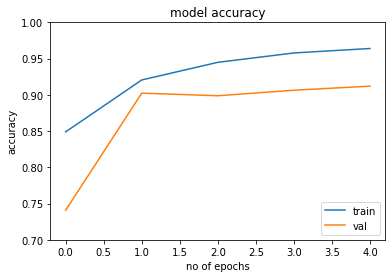

In [ ]:
from matplotlib import pyplot as plt
#why  history = model.fit(X_test, y_test,validation_split = 0.01, epochs=5, batch_size=32)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('no of epochs')
plt.ylim([0.7, 1])
plt.legend(['train', 'val'], loc='lower right')
plt.show()
#print("The model is being evaluated")
#test_loss, test_acc = model.evaluate(X_test,y_test, verbose=2)
#print("The accuracy of the model is:")
#test_acc=round(test_acc*100, 2)
#print(test_acc)

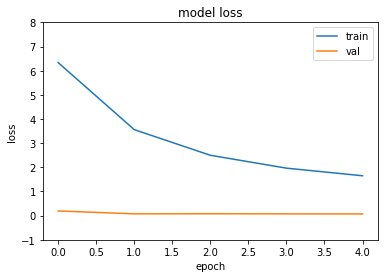

In [ ]:
import matplotlib.pyplot as plt 
#plt.plot(history.history['loss'],   marker='s', color='b', ms=5, mfc='k',linewidth=1.8)
#plt.plot(history.history['val_loss'],  marker='s', color='r', ms=5, mfc='k',linewidth=1.8)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylim([-1, 8])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

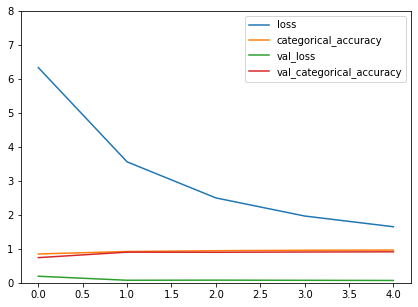

In [ ]:
pd.DataFrame(history.history).plot(figsize=(7,5))
plt.ylim([0, 8])
plt.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Add traces
fig.add_trace(
    go.Scatter( y=history.history['val_loss'], name="val_loss"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter( y=history.history['loss'], name="loss"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter( y=history.history['val_categorical_accuracy'], name="val_categorical_accuracy"),
    secondary_y=True,
)
fig.add_trace(
    go.Scatter( y=history.history['categorical_accuracy'], name="val accuracy"),
    secondary_y=True,
)
# Add figure title
fig.update_layout(
    title_text="Loss/Accuracy of CNN Model"
)
# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)
fig.show()

In [ ]:
predicts = []
for a,b in predit:
    if a >=b:
        predicts.append(0)
    else:
        predicts.append(1)
len(predicts)

52308

In [ ]:
from sklearn.metrics import plot_confusion_matrix
cm = confusion_matrix(list(predicts), list((dataTest.values[:,0])))
print(cm)
CR = classification_report(list((dataTest.values[:,0])),list(predicts))
print(CR)
#print(145/4702)
#i=0
#for j in list(data.values[9500:,2]+1):
#     if j==1:
#         i +=1
#print(i)
#plt.show()
#plot_confusion_matrix_from_data(list((dataTest.values[:,0])), list(predicts))

[[49982     1]
 [ 1739   586]]
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98     51721
         1.0       0.25      1.00      0.40       587

    accuracy                           0.97     52308
   macro avg       0.63      0.98      0.69     52308
weighted avg       0.99      0.97      0.98     52308



In [ ]:
print(pd.DataFrame(predit))

              0             1
0      0.993257  6.743128e-03
1      0.999999  1.238484e-06
2      0.999925  7.544005e-05
3      0.997809  2.191290e-03
4      0.999681  3.189152e-04
...         ...           ...
52303  0.999999  1.241764e-06
52304  0.999989  1.129098e-05
52305  0.999996  3.884648e-06
52306  0.999999  6.061716e-07
52307  0.999952  4.844243e-05

[52308 rows x 2 columns]


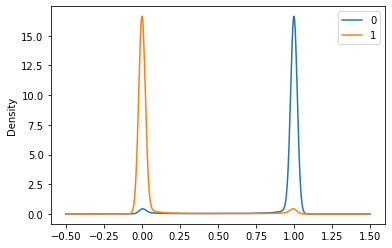

In [ ]:
pd.DataFrame(predit).plot.density()

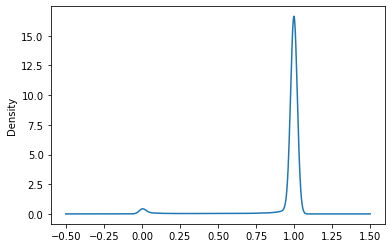

In [ ]:
pd.DataFrame(predit).iloc[:,0].plot.density()

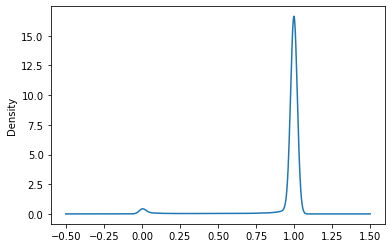

In [ ]:
pd.DataFrame(predit).iloc[:,0].plot.density()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0, 0.5, 'frequency distribution')

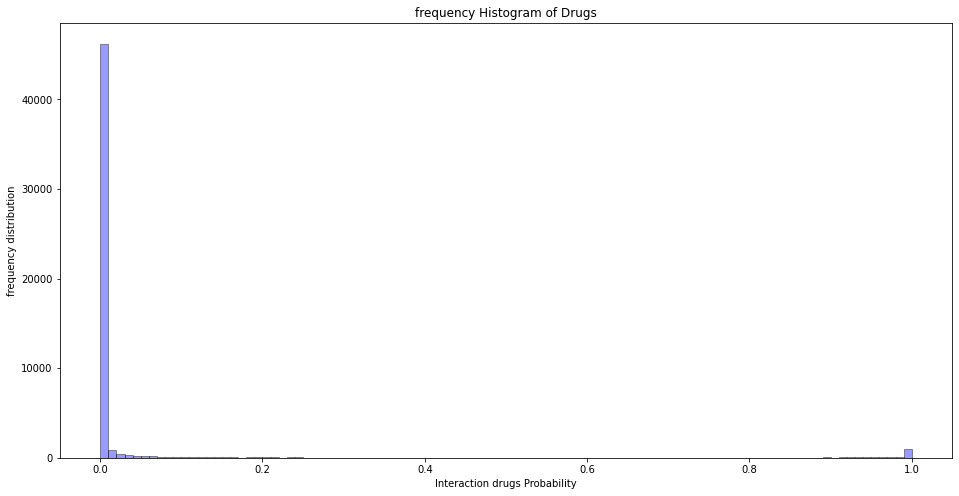

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)

# matplotlib histogram
# plt.hist(pd.DataFrame(predit).iloc[:,1], color = 'blue', edgecolor = 'black',
#          bins = int(200))

# seaborn histogram
sns.distplot(pd.DataFrame(predit).iloc[:,1], hist=True, kde=False, 
             bins=int(100), color = 'blue',
             hist_kws={'edgecolor':'black'})

# sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=True, 
#              bins=int(200), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})
# Add labels
plt.title('frequency Histogram of Drugs')
plt.xlabel('Interaction drugs Probability')
plt.ylabel('frequency distribution')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0, 0.5, 'frequency distribution')

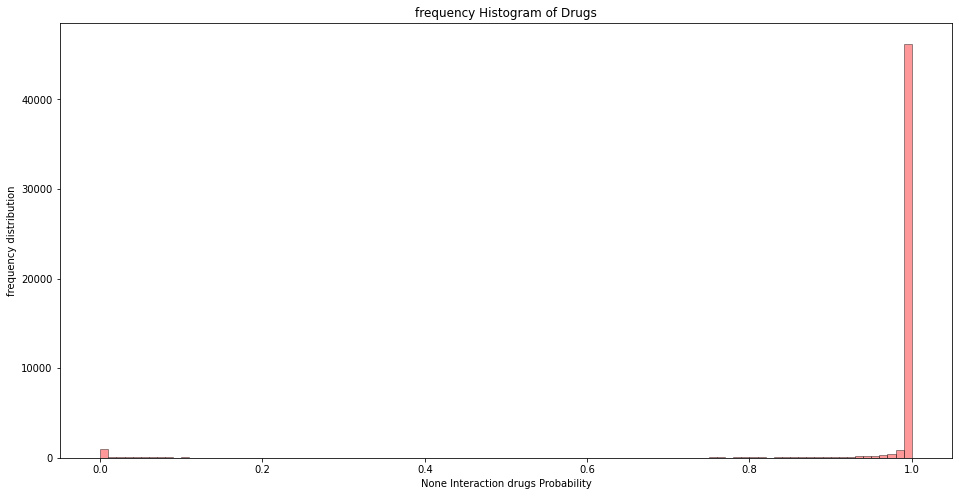

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16,8)

# matplotlib histogram
# plt.hist(pd.DataFrame(predit).iloc[:,1], color = 'blue', edgecolor = 'black',
#          bins = int(200))

# seaborn histogram

sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=False, 
             bins=int(100), color = 'red',
             hist_kws={'edgecolor':'black'})
# sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=True, 
#              bins=int(200), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})
# Add labels
plt.title('frequency Histogram of Drugs')
plt.xlabel('None Interaction drugs Probability')
plt.ylabel('frequency distribution')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0, 0.5, 'frequency distribution')

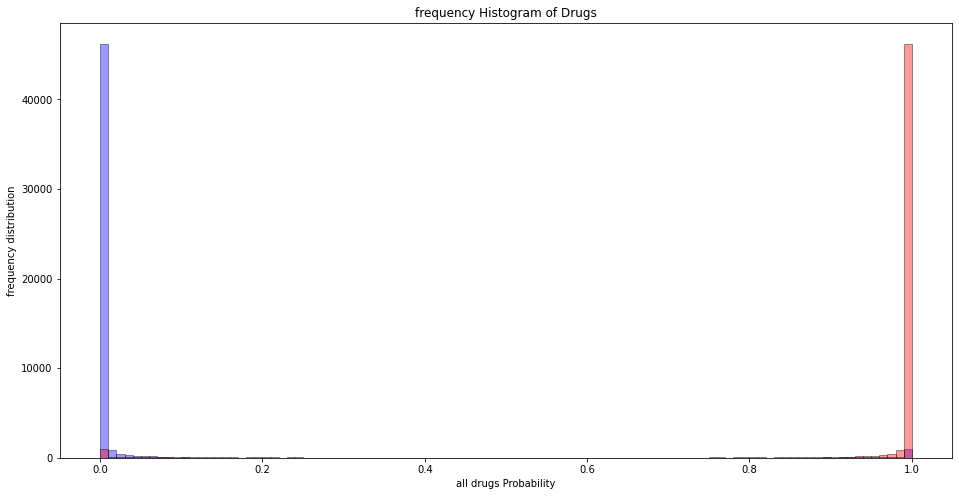

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16,8)

# matplotlib histogram
# plt.hist(pd.DataFrame(predit).iloc[:,1], color = 'blue', edgecolor = 'black',
#          bins = int(200))

# seaborn histogram
sns.distplot(pd.DataFrame(predit).iloc[:,1], hist=True, kde=False, 
             bins=int(100), color = 'blue',
             hist_kws={'edgecolor':'black'})

sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=False, 
             bins=int(100), color = 'red',
             hist_kws={'edgecolor':'black'})
# sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=True, 
#              bins=int(200), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})
# Add labels
plt.title('frequency Histogram of Drugs')
plt.xlabel('all drugs Probability')
plt.ylabel('frequency distribution')

<div class="markdown-google-sans">
  <h1>Welcome to Colab!</h1>
</div>

If you're already familiar with Colab, check out this video to learn about interactive tables, the executed code history view, and the command palette.

<center>
  <a href="https://www.youtube.com/watch?v=rNgswRZ2C1Y" target="_blank">
  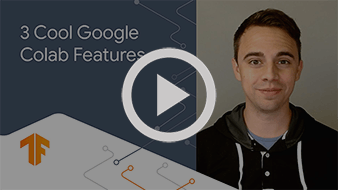
  </a>
</center>

In [ ]:

import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Softmax, Dropout, MaxPooling2D
from keras import optimizers
from keras import metrics as kmetr
from tensorflow.keras.utils import plot_model

import pydot

#### test & train split
data = pd.read_csv('/content/drive/MyDrive/F.csv')
data.head()

dataTrain = data.iloc[int(0.3*len(data.iloc[:,0])):,:]
dataTest = data.iloc[:int(0.3*len(data.iloc[:,0])),:]


X_train = dataTrain.values[:,1:]
y_train = dataTrain.values[:,0].astype(int)
trainNum = len(X_train)
print(trainNum)
del dataTrain

X_test = dataTest.values[:,1:]
y_test = dataTest.values[:,0].astype(int)
testNum = len(X_test)
del data

transformer = Normalizer().fit(X_train)  # fit does nothing.
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)


#reshape data to fit model
X_train = X_train.reshape(trainNum,25,25,1)
X_test = X_test.reshape(testNum,25,25,1)

# y_train = y_train + 1
# y_test  = y_test + 1
# y_train = y_train / 2
# y_test  = y_test / 2
# print(y_train[0:5], y_test[0:5])

#one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=4, activation='relu',\
                 input_shape=(25,25,1)))
# model.add(Conv2D(64, kernel_size=4, activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=4, activation='relu'))
model.add(Conv2D(16, kernel_size=4, activation='relu'))

model.add(Conv2D(8, kernel_size=4, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense( 32, activation='relu'))
model.add(Dropout(0.1))
# model.add(Dense( 16, activation='relu'))
model.add(Dense(2, activation='relu'))
# model.add(Softmax(128))
model.summary()


adam = tf.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
# model.compile(loss='hinge', optimizer=adam, metrics=[kmetr.categorical_accuracy])
model.compile(optimizer='adam', loss='categorical_crossentropy',\
              metrics=['categorical_accuracy']) ## Minist

### Load the model's saved weights.
# model.load_weights('cnn_4_epoch.h5')

class_weight = {0: 5,
                1: 95
               }


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, class_weight=class_weight)
# history = model.fit(X_train, y_train, epochs=1)

### Saveing the Model
model.save_weights('cnn_2_epoch.h5')
predit = model.predict(X_test)

print(predit[:4])

prec, rec, thr = precision_recall_curve(y_test[:,1], predit[:,1])
aupr_val = auc(rec, prec)
fpr, tpr, thr = roc_curve(y_test[:,1], predit[:,1])
auc_val = auc(fpr, tpr)
print(aupr_val,auc_val)





NameError: ignored

<div class="markdown-google-sans">
  <h1>What is Colab?</h1>
</div>

Colab, or "Colaboratory", allows you to write and execute Python in your browser, with 
- Zero configuration required
- Access to GPUs free of charge
- Easy sharing

Whether you're a **student**, a **data scientist** or an **AI researcher**, Colab can make your work easier. Watch [Introduction to Colab](https://www.youtube.com/watch?v=inN8seMm7UI) to learn more, or just get started below!

<div class="markdown-google-sans">

## **Getting started**
</div>

The document you are reading is not a static web page, but an interactive environment called a **Colab notebook** that lets you write and execute code.

For example, here is a **code cell** with a short Python script that computes a value, stores it in a variable, and prints the result:

In [ ]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter". To edit the code, just click the cell and start editing.

Variables that you define in one cell can later be used in other cells:

In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

Colab notebooks allow you to combine **executable code** and **rich text** in a single document, along with **images**, **HTML**, **LaTeX** and more. When you create your own Colab notebooks, they are stored in your Google Drive account. You can easily share your Colab notebooks with co-workers or friends, allowing them to comment on your notebooks or even edit them. To learn more, see [Overview of Colab](/notebooks/basic_features_overview.ipynb). To create a new Colab notebook you can use the File menu above, or use the following link: [create a new Colab notebook](http://colab.research.google.com#create=true).

Colab notebooks are Jupyter notebooks that are hosted by Colab. To learn more about the Jupyter project, see [jupyter.org](https://www.jupyter.org).

<div class="markdown-google-sans">

## Data science
</div>

With Colab you can harness the full power of popular Python libraries to analyze and visualize data. The code cell below uses **numpy** to generate some random data, and uses **matplotlib** to visualize it. To edit the code, just click the cell and start editing.

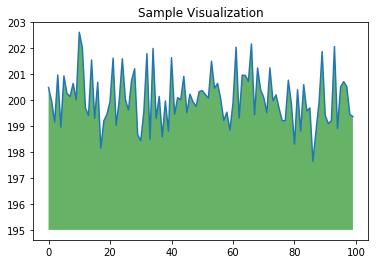

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)

plt.title("Sample Visualization")
plt.show()

You can import your own data into Colab notebooks from your Google Drive account, including from spreadsheets, as well as from Github and many other sources. To learn more about importing data, and how Colab can be used for data science, see the links below under [Working with Data](#working-with-data).

<div class="markdown-google-sans">

## Machine learning
</div>

With Colab you can import an image dataset, train an image classifier on it, and evaluate the model, all in just [a few lines of code](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb). Colab notebooks execute code on Google's cloud servers, meaning you can leverage the power of Google hardware, including [GPUs and TPUs](#using-accelerated-hardware), regardless of the power of your machine. All you need is a browser.

Colab is used extensively in the machine learning community with applications including:
- Getting started with TensorFlow
- Developing and training neural networks
- Experimenting with TPUs
- Disseminating AI research
- Creating tutorials

To see sample Colab notebooks that demonstrate machine learning applications, see the [machine learning examples](#machine-learning-examples) below.

<div class="markdown-google-sans">

## More Resources

### Working with Notebooks in Colab

</div>

- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)
- <img src="/img/new.png" height="20px" align="left" hspace="4px" alt="New"></img>
 [TensorFlow 2 in Colab](/notebooks/tensorflow_version.ipynb)

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### Working with Data
</div>

- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb) 
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### Machine Learning Crash Course

<div>

These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
</div>

- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TensorFlow with TPUs](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### Featured examples

</div>

- [NeMo Voice Swap](https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/VoiceSwapSample.ipynb): Use Nvidia's NeMo conversational AI Toolkit to swap a voice in an audio fragment with a computer generated one.

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.
